In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read in training set data
sfcrimes = pd.read_csv("train.csv")
sfcrimes.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
# Turn crime category into categorical variable

sfcrimes["Category"] = sfcrimes["Category"].astype("category")

from sklearn.preprocessing import LabelEncoder
cat_codes = LabelEncoder()
cat_codes.fit(sfcrimes["Category"].cat.categories)

sfcrimes["CatCodes"] = cat_codes.transform(sfcrimes["Category"])

In [12]:
# Some exploratory plots

## Split into test and training
from sklearn.cross_validation import train_test_split
train, test = train_test_split(sfcrimes, test_size=0.3, random_state=333)

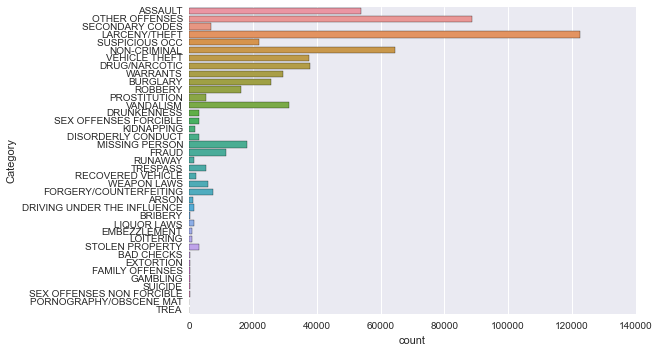

In [98]:
## Distribution of crime categories

sns.countplot(y="Category", data=train)

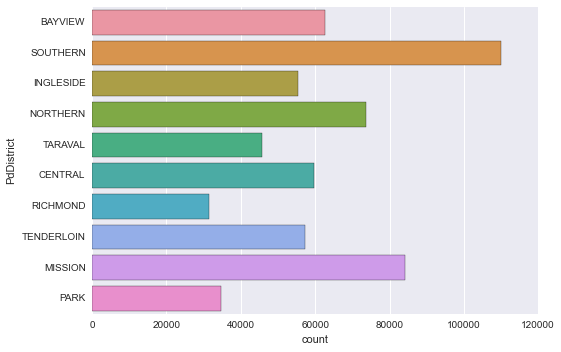

In [97]:
## Distribution of police districts

sns.countplot(y="PdDistrict", data=train)

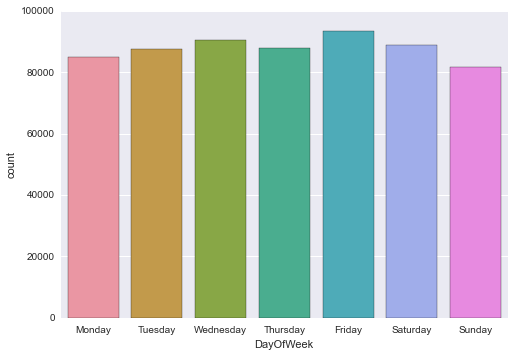

In [96]:
## Distribution of day of week

sns.countplot(x="DayOfWeek",
              data=train,
              order=[x + "day" for x in ["Mon", "Tues", "Wednes", "Thurs",
                                       "Fri", "Satur", "Sun"]])

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


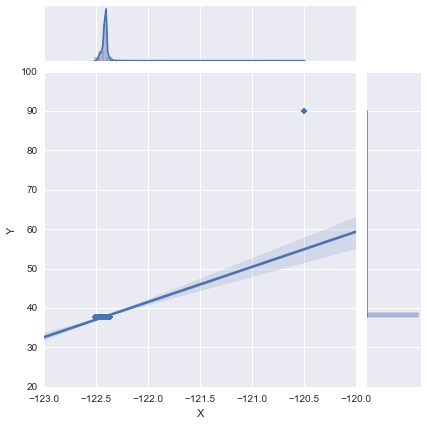

In [47]:
## Distribution of locations

geo = sns.JointGrid(x='X', y='Y', data=train)
geo.plot(sns.regplot, sns.distplot)

## What to do about extreme outliers in both longitude and latitude?

In [13]:
# Model 1: normalized empirical probabilities

## Predict on testing data based on mean probability for each category 
## in training data
model1 = train["CatCodes"].value_counts()/len(train.index)
model1_pred = np.tile(model1, (len(test.index), 1))
model1_pred.shape

(263415, 39)

In [14]:
## Evaluate Model 1's performance using log-loss metric from Kaggle

from sklearn.metrics import log_loss
log_loss(test["CatCodes"], model1_pred)

5.4603475160606845

In [11]:
# Model 2: using only police district

## Create dummy variables for police district categorical variable
model2_features = pd.get_dummies(train["PdDistrict"], 
                                 prefix="Pd")
model2_features.head(5)

,Pd_BAYVIEW,Pd_CENTRAL,Pd_INGLESIDE,Pd_MISSION,Pd_NORTHERN,Pd_PARK,Pd_RICHMOND,Pd_SOUTHERN,Pd_TARAVAL,Pd_TENDERLOIN
710747,1,0,0,0,0,0,0,0,0,0
67284,0,0,0,0,0,0,0,1,0,0
269629,0,0,1,0,0,0,0,0,0,0
716054,0,0,0,0,1,0,0,0,0,0
216556,0,0,0,0,0,0,0,0,1,0


In [12]:
## Predict on testing data using multinomial logistic regression 
## based on police district dummies

from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression().fit(model2_features, 
                                  train["CatCodes"])
test_features = pd.get_dummies(test["PdDistrict"], prefix="Pd")
model2_pred = model2.predict_proba(test_features)
model2_pred.shape

(263415, 39)

In [13]:
## Evaluate Model 2's performance using log-loss metric from Kaggle

log_loss(test["CatCodes"], model2_pred)

2.617136951006521

In [61]:
## Generate submission using Kaggle's test data

kaggle_test = pd.read_csv("test.csv")
kaggle_features = pd.get_dummies(kaggle_test["PdDistrict"], prefix="Pd")
kaggle_pred = model2.predict_proba(kaggle_features)
colnames = cat_codes.inverse_transform(model2.classes_)
submission = pd.DataFrame(kaggle_pred, 
                          columns=colnames)
submission.to_csv(path_or_buf="/Users/hanalee/sfcrimes/model2.csv",
                  index_label="Id")

In [16]:
# Model 3: adding day of week to police district

## Create dummy variables for day of week categorical variable

model3_features = pd.concat([model2_features, 
                             pd.get_dummies(train["DayOfWeek"])],
                            axis=1)

model3_features.head(5)

,Pd_BAYVIEW,Pd_CENTRAL,Pd_INGLESIDE,Pd_MISSION,Pd_NORTHERN,Pd_PARK,Pd_RICHMOND,Pd_SOUTHERN,Pd_TARAVAL,Pd_TENDERLOIN,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
710747,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
67284,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
269629,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
716054,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
216556,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [18]:
## Predict on testing data using multinomial logistic regression 
## based on police district and day of week

model3 = LogisticRegression().fit(model3_features, 
                                  train["CatCodes"])
test_features = pd.concat([pd.get_dummies(test["PdDistrict"], prefix="Pd"),
                           pd.get_dummies(test["DayOfWeek"])],
                          axis=1)               
model3_pred = model3.predict_proba(test_features)
model3_pred.shape

(263415, 39)

In [19]:
## Evaluate Model 3's performance using log-loss metric from Kaggle

log_loss(test["CatCodes"], model3_pred)

## Not especially better than doing police districts alone

2.6141621112580964

In [8]:
# Model 4: random forests

from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier

kf = KFold(len(sfcrimes.index), n_folds=5, shuffle=True, random_state=333)

In [17]:
## Predict using random forests and 5-fold cross-validation

model4_features = pd.concat([pd.get_dummies(sfcrimes["PdDistrict"],
                                            prefix="Pd"),
                             pd.get_dummies(sfcrimes["DayOfWeek"])],
                            axis=1)
rf = RandomForestClassifier(n_estimators=100,
                            random_state=333)

def log_loss_kfold(alg, train_features, train_target,
                   test_features, test_target):
    train_fit = alg.fit(train_features, train_target)
    test_pred = train_fit.predict_proba(test_features)
    return log_loss(test_target, test_pred)

scores = [log_loss_kfold(rf,
                         model4_features.iloc[train_idx],
                         sfcrimes["CatCodes"].iloc[train_idx],
                         model4_features.iloc[test_idx],
                         sfcrimes["CatCodes"].iloc[test_idx])
          for train_idx, test_idx in kf]
sum(scores)/len(scores)

2.6182062932050645

In [ ]:
## Parameters to tune:
## max_features, max_depth, min_samples_leaf

In [ ]:
# Model 5: gradient boosting

# Model 6: extreme gradient boosting